# NLP

Analyse des reviews que des utilisateurs laissent sur les apps de rencontre hébergées sur les App stores.
Le dataset dont nous allons nous servir est issu de kaggle:  https://www.kaggle.com/sidharthkriplani/datingappreviews.

## Import des librairies

Nous aurons besoin de scikit-learn, pandas, numpy et ntlk la librairie d'analyse de langage naturel.


In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
#NLP libs
import re, string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\simon\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\simon\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\simon\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Préparation des données

Le dataset n'est pas encore propre et il faut le traiter avant toute chose.

### Nettoyage

- Gérer les NaNs (les remplacer par des valeurs qui ont du sens ou tout simplement supprimer la ligne pour les données critiques)
- S'assurer d'avoir un index unique pour chaque ligne
- 

In [2]:
df = pd.read_csv("./DatingAppReviewsDataset.csv", index_col=0)
print("On vérifie que les index sont bien des valeurs uniques: ", df.index.is_unique)

print("On va donc réécrire cet index.")
df = df.reset_index()
df = df.drop("index", axis = 1)

print("On va regarder si des NaNs existent dans le dataset")
print(df.isna().any())
print("Name et Review contiennent des NaNs on va donc les nettoyer")

On vérifie que les index sont bien des valeurs uniques:  False
On va donc réécrire cet index.
On va regarder si des NaNs existent dans le dataset
Name          True
Review        True
Rating       False
#ThumbsUp    False
Date&Time    False
App          False
dtype: bool
Name et Review contiennent des NaNs on va donc les nettoyer


In [3]:
#On supprime les rows si Review, Rating ou App sont des nan. Des lignes avec #ThumbsUp,	Date&Time et Name étant des NAN existent 
# mais leur impact est limité dans notre analyse 

df.dropna(inplace=True, subset=["Review", "Rating", "App"])
df["Name"].fillna("Not available", inplace=True)

print(df.isna().any())
print("On n'a plus aucun NaNs et on s'est débarrasé des rows ayant des reviews vides.")

Name         False
Review       False
Rating       False
#ThumbsUp    False
Date&Time    False
App          False
dtype: bool
On n'a plus aucun NaNs et on s'est débarrasé des rows ayant des reviews vides.


### Exploration des données

Ici on va tracer des courbes en essayant de faire parler les données. Il s'agit d'une analyse exploratoire.

,#ThumbsUp
Rating,
0,0
1,825165
2,184295
3,98943
4,82624
5,86775


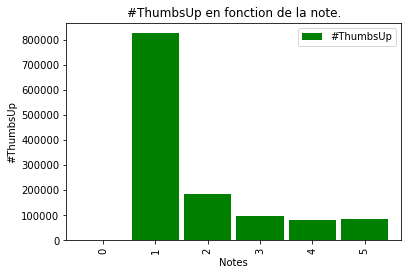

Les commentaires ayant reçu une note de 1 sont les plus souvent upvotés et de loin.


In [4]:
#Dataframe contenant la somme des thumbs up pour chaque note attribuée aux commentaires
comp_rating_thumbs_up = df.groupby("Rating").sum()
display(comp_rating_thumbs_up)

#On reset l'index car rating a été considéré comme l'index:
comp_rating_thumbs_up.reset_index().plot.bar(x="Rating", y="#ThumbsUp", width=0.9, color="g")

plt.xlabel("Notes")
plt.ylabel("#ThumbsUp")
plt.title("#ThumbsUp en fonction de la note.");
plt.show();

print("Les commentaires ayant reçu une note de 1 sont les plus souvent upvotés et de loin.")

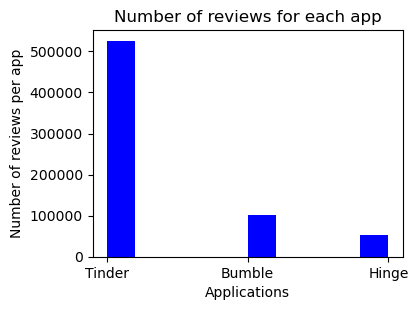

Tinder est l'application la plus notée


In [5]:
plt.figure(dpi=100, figsize=(4,3))
plt.hist(df.App, color="blue", stacked=True)
plt.xlabel("Applications")
plt.ylabel("Number of reviews per app")
plt.title("Number of reviews for each app")
plt.show();
print("Tinder est l'application la plus notée")


On peut voir ici que l'application la mieux notée est Hinge


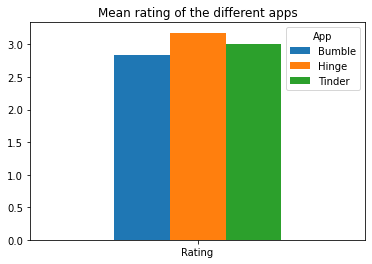

In [69]:
temp_df = df.groupby("App").agg({"Rating": np.mean}).T
temp_df.plot.bar(rot=0);
plt.title("Mean rating of the different apps")
print("On peut voir ici que l'application la mieux notée est Hinge")

In [7]:
display(df.groupby("App").agg({"Rating": [min, max, np.mean, np.median]}))
print("Hinge est l'application qui possède le plus de notes positives. Néanmoins c'est aussi celle qui a le moins de reviews.")
print("Avec un si petit delta dans la note moyenne associée aux apps, la note moyenne de Tinder, ayant 4 fois plus de reviews que Hinge est plus fiable.")

Rating                     
          min max      mean median
App                               
Bumble      1   5  2.832252    3.0
Hinge       1   5  3.180895    4.0
Tinder      0   5  3.007847    3.0

Hinge est l'application qui possède le plus de notes positives. Néanmoins c'est aussi celle qui a le moins de reviews.
Avec un si petit delta dans la note moyenne associée aux apps, la note moyenne de Tinder, ayant 4 fois plus de reviews que Hinge est plus fiable.


### Séparation des variables et balance des données

On sépare ici le jeu de données en 2 afin d'extraire les variables explicatives de la variable cible. 

Notre variable explicative est ici "Review" et la variable cible est "Rating"

In [8]:
print("On est surtout intéressés par les Reviews et la note associée donc on drop les colonnes qui ne nous servent pas.")
#X = df.drop(["Rating", "#ThumbsUp", "Name", "Date&Time", "App" ], axis = 1)
X = df.Review
y = df.Rating

On est surtout intéressés par les Reviews et la note associée donc on drop les colonnes qui ne nous servent pas.


Nous avons besoin de savoir si les données sont bien réparties entre les différents "Rating" afin d'avoir un jeu de donnée bien balancé:

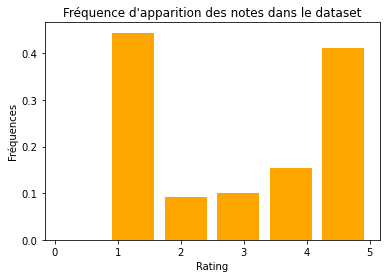

In [9]:
plt.hist(y, density=True, bins=6, rwidth=0.8, color="orange")
plt.xlabel("Rating")
plt.ylabel("Fréquences")
plt.title("Fréquence d'apparition des notes dans le dataset")
plt.show();
#print("On a un dataset assez inégal on va donc le retravailler pour ne plus avoir une surpopulation de 1 et de 5")

@TODO: Balancer le dataset

In [10]:
df

,Name,Review,Rating,#ThumbsUp,Date&Time,App
0,linah sibanda,On this app i cant find a partner,5,0,18-02-2022 01:19,Tinder
1,Norman Johnson,Tinder would be so much better if we could spe...,3,0,18-02-2022 01:16,Tinder
2,David Hume,Still doesn't correctly notify matches or mess...,1,0,18-02-2022 01:11,Tinder
3,Last 1 Standing,"Got banned because I updated my bio to say ""I ...",2,0,18-02-2022 01:11,Tinder
4,Arthur Magamedov,Love it!,5,0,18-02-2022 01:06,Tinder
...,...,...,...,...,...,...
681989,A Google user,Useless - I'm in the UK and it tells me i'm ov...,2,5,12-07-2017 01:44,Hinge
681990,Brian Shook,I can't get past the initial set up. It won't...,1,11,12-07-2017 01:36,Hinge
681991,A Google user,This is incredible! A quality dating app for A...,5,1,12-07-2017 01:32,Hinge
681992,A Google user,"""Over Water"" ... Can't choose location.",2,8,12-07-2017 01:28,Hinge
